In [1]:
TRAIN =  '/kaggle/input/processed-dr/preprocessed-diabetic-retinopathy'

First let's load up our labels.

In [2]:
import pandas as pd

LABELS = TRAIN + '/labels.csv'
labels_df = pd.read_csv(filepath_or_buffer=LABELS)
labels_df.head()

image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

What do our class counts look like?

In [3]:
labels_df['level'].value_counts().to_frame().T

level      0     2     1    3    4
count  25802  5288  2438  872  708

We're going to balance our classes via the labels DataFrame.

In [4]:
t_df = pd.concat(axis='index', objs=[labels_df[labels_df['level'] == level].sample(n=100, random_state=2026) for level in range(5)])
keep = [item + '.jpeg' for item in t_df['image']]
t_df['level'].value_counts().to_frame().T

level    0    1    2    3    4
count  100  100  100  100  100

Next let's introduce some code to get image embeddings using ResNeXt.

In [5]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


100%|██████████| 95.8M/95.8M [00:04<00:00, 21.5MB/s]


We built our keep list above and we're going to use it to only load the image embeddings and thumbnails for the data we want to keep.

In [6]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from os.path import isdir
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGBA').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) if basename(input_file) in keep]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') if isdir(folder) }
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 500 rows of Images  in 0:01:01.817316
done in 0:01:01.853513


Next let's merge the labels into our big DataFrame.

In [7]:
labels_df['name'] = labels_df['image'] + '.jpeg'
train_df = train_df.merge(right=labels_df, on='name', how='inner')
train_df['level'] = train_df['level'].astype(str)
train_df.head()

tag              name  \
0  Images  36055_right.jpeg   
1  Images  19878_right.jpeg   
2  Images  33492_right.jpeg   
3  Images    6374_left.jpeg   
4  Images    2810_left.jpeg   

                                               value  \
0  [0.009876446, 0.4821156, 0.0, 0.0, 0.0, 0.2603...   
1  [0.3873074, 0.8507874, 0.0, 0.0, 0.0, 0.0, 0.0...   
2  [0.21281992, 0.045496132, 0.0, 0.0, 0.03135806...   
3  [0.4853686, 0.0, 0.0, 0.007024243, 0.0, 0.2714...   
4  [0.02060453, 0.019398954, 0.0, 0.0, 0.0, 0.0, ...   

                                                 png        image level  
0  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  36055_right     2  
1  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  19878_right     1  
2  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  33492_right     1  
3  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...    6374_left     1  
4  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...    2810_left     4

Our classes are balanced by construction.

In [8]:
train_df['level'].value_counts(normalize=True).to_frame().T

level         2    1    4    0    3
proportion  0.2  0.2  0.2  0.2  0.2

No, in fact we probably only have one class that is well-represented. Let's proceed and iterate.

Let's use TSNE to add x/y coordinates based on our image vectors. We can use them to build an exploratory scatter plot.

In [9]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.003s...
[t-SNE] Computed neighbors for 500 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 2.747456
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.916412
[t-SNE] KL divergence after 1000 iterations: 1.140224


Let's plot.

In [10]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'level', 'x', 'y']].sample(n=min(len(train_df) - 1, 10000)))
factor_count = max(train_df['level'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'level', palette=palette, factors=train_df['level'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: retinopathy', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@level</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

This is not encouraging. Our data looks mostly random, with maybe a little bit of clustering for level 4. Let's build a model and see what we get.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['level'], test_size=0.25, random_state=2025, stratify=train_df['level'])
logreg = LogisticRegression(max_iter=10000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test), zero_division=0.0))

model fit in 1421 iterations
accuracy: 0.3520
f1: 0.3512
              precision    recall  f1-score   support

           0       0.29      0.36      0.32        25
           1       0.36      0.36      0.36        25
           2       0.24      0.20      0.22        25
           3       0.38      0.36      0.37        25
           4       0.50      0.48      0.49        25

    accuracy                           0.35       125
   macro avg       0.35      0.35      0.35       125
weighted avg       0.35      0.35      0.35       125



This is really bad, but better than random. Since we balanced our classes a dummy model would give us an accuracy of 0.2, and we're getting an f1 of 0.35. Lousy, but better than random.

<Axes: xlabel='probability', ylabel='Count'>

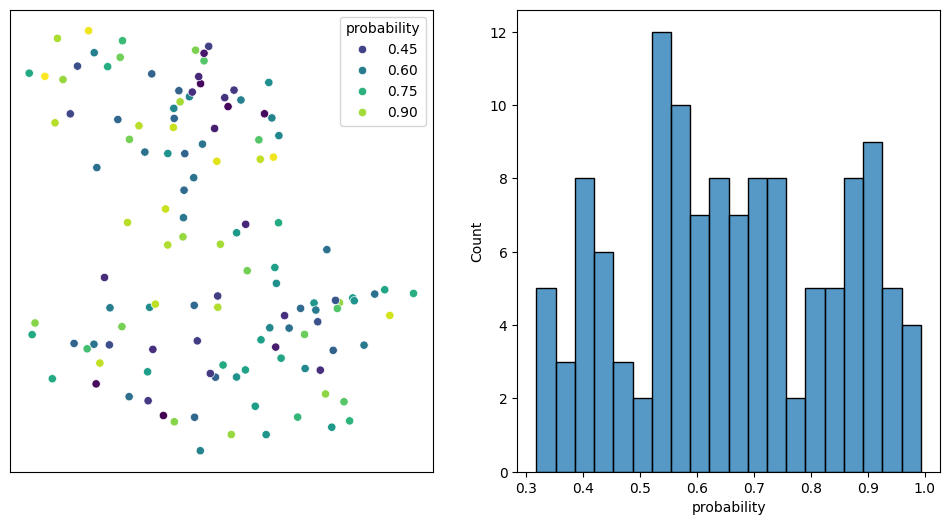

In [12]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis', )
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)